In [0]:
import matplotlib.pyplot as plt

In [0]:
import torch
import numpy as np
from torch.distributions.multivariate_normal import MultivariateNormal

class VBGP:
  def __init__(self, num_inducing_points, dim ):
    self.M = num_inducing_points
    self.D = dim
    self.device = "cuda"

    self.theta0 = torch.rand(1, requires_grad=True )
    self.theta1 = torch.rand(1, requires_grad=True )
    self.theta2 = torch.rand(1, requires_grad=True )
    self.theta3 = torch.rand(1, requires_grad=True )
    self.inducing_points = torch.tensor( np.random.rand(self.M, self.D)*20, requires_grad=True  )

  def k(self, xi, xj):
    #return torch.exp(self.theta0) * torch.exp(-0.5 * torch.exp(self.theta1) * torch.sum((xi - xj) * (xi - xj))) + self.theta2 + self.theta3 * torch.sum(xi * xj)
    #return torch.exp(self.theta0) * torch.exp(-0.5 * torch.exp(self.theta1) * torch.sum((xi - xj) * (xi - xj), 2)) 
    return 1.0 * torch.exp(-0.5 * 1.0 * torch.sum((xi - xj) * (xi - xj), 2)) 
  
  def cov(self, xi, xj ):
    a = xi.view(-1,1,self.D).repeat(1, len(xj), 1)
    b = xj.view(1,-1,self.D).repeat(len(xi), 1, 1)
    return self.k(a,b).float()

  def learn(self, xt, yt ):
    self.xt = torch.Tensor(xt)
    self.yt = torch.Tensor(yt)
    N = len(xt)

    # to gpu
    self.xt.to(self.device)
    self.yt.to(self.device)
    self.theta0.to(self.device)
    self.theta1.to(self.device)
    self.inducing_points.to(self.device)

    optimizer = torch.optim.Adam( [self.theta0, self.theta1, self.inducing_points], lr=0.1)

    self.sig2 = 1.0

    for i in range(10000):
      # カーネル行列を定義
      self.Kmm = self.cov( self.inducing_points, self.inducing_points )
      self.Kmm_inv = torch.inverse( self.Kmm+torch.eye(self.M, self.M)*0.001 )
      self.Knm = self.cov( self.xt, self.inducing_points )
      self.Kmn = torch.t( self.Knm )
      self.Knn = self.cov( self.xt, self.xt )
      self.Knn_ = torch.mm( torch.mm(self.Knm, self.Kmm_inv), self.Kmn )

      # loss関数を定義
      gauss = MultivariateNormal(torch.zeros(N), self.sig2*torch.eye(N)+self.Knn_)
      loss = -gauss.log_prob(self.yt) + torch.trace( self.Knn - self.Knn_ ) / (2*self.sig2)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 論文中のΣ，A,B
      self.S = torch.inverse( self.Kmm + 1/self.sig2 * torch.mm(self.Kmn, self.Knm) + torch.eye(self.M, self.M)*0.001 )
      A = torch.mm( torch.mm(self.Kmm, self.S ), self.Kmm )
      self.B = torch.mm(torch.mm(self.Kmm_inv, A), self.Kmm_inv )

      if i%500==0:
        print(loss)  
        self.plot()


  def plot(self):
      x = np.linspace( 0,20,100 )
      mus, sigmas = self.predict( x.reshape(-1,1) )
      plt.plot( x, mus )
      
      y_max = mus + np.sqrt(sigmas.flatten())
      y_min = mus - np.sqrt(sigmas.flatten())

      plt.fill_between(x, y_min, y_max, facecolor="lavender" , alpha=0.9 , edgecolor="lavender"  )

      for p in self.inducing_points.detach().numpy():
        plt.plot( p, [0.0], "kx" )
      plt.plot(self.xt, self.yt)
      plt.show()


  def predict( self, x ):
    x = torch.tensor(x)
    mus = []
    sigmas = []
    K = len(x)

    for k in range(K):
        Kxm = self.cov( x[k], self.inducing_points )
        Kmx = torch.t( Kxm )

        sig = self.cov(x[k], x[k]) 
        sig += -torch.mm(torch.mm( Kxm, self.Kmm_inv), Kmx)
        sig += torch.mm( torch.mm( Kxm, self.B ), Kmx )

        mu = torch.mm(Kxm, self.Kmm_inv )
        mu = torch.mm(mu, 1/self.sig2 * torch.mm( torch.mm( torch.mm( self.Kmm, self.S ), self.Kmn), self.yt.reshape(-1,1) ) )
        
        mus.append(mu.detach().numpy().flatten()[0])
        sigmas.append(sig.detach().numpy().flatten()[0])
    
    return np.array(mus), np.array(sigmas)



In [0]:
gp = VBGP( 20, 1 )

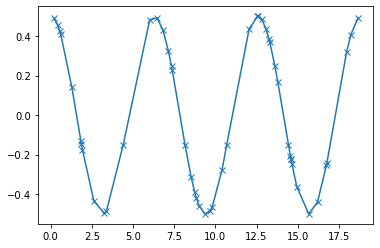

In [13]:
xt = np.sort(np.random.rand(50)*20)
yt = np.cos(xt)/2

plt.plot( xt, yt, "x-" )

tensor(57.4977, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


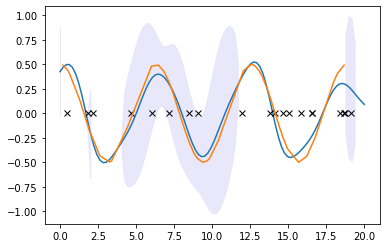

tensor(56.3423, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


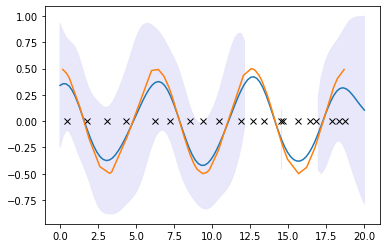

tensor(56.3386, grad_fn=<AddBackward0>)


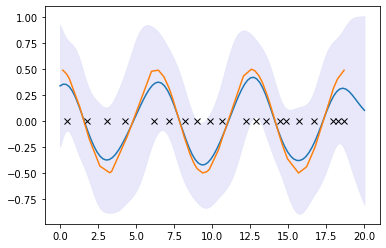

tensor(56.3376, grad_fn=<AddBackward0>)


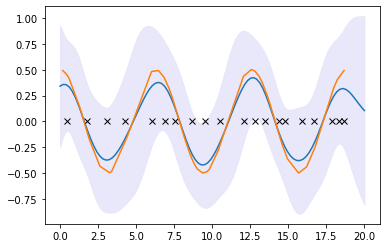

tensor(56.3376, grad_fn=<AddBackward0>)


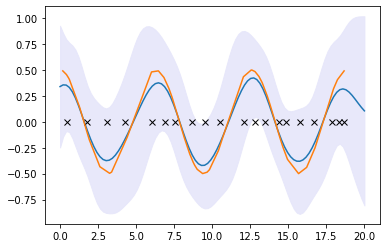

tensor(56.3376, grad_fn=<AddBackward0>)


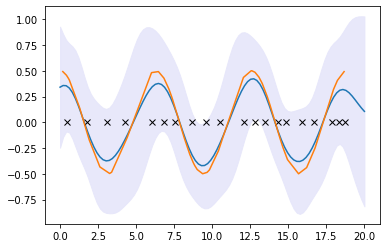

tensor(56.3376, grad_fn=<AddBackward0>)


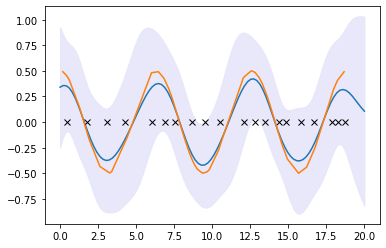

tensor(56.3376, grad_fn=<AddBackward0>)


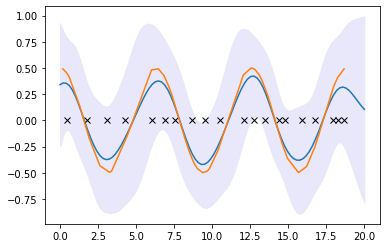

tensor(56.3395, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


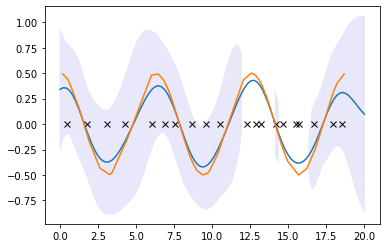

tensor(56.3374, grad_fn=<AddBackward0>)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:93: RuntimeWarning: invalid value encountered in sqrt
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:94: RuntimeWarning: invalid value encountered in sqrt


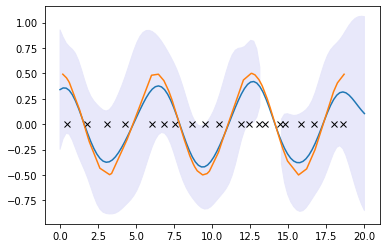

tensor(56.3271, grad_fn=<AddBackward0>)


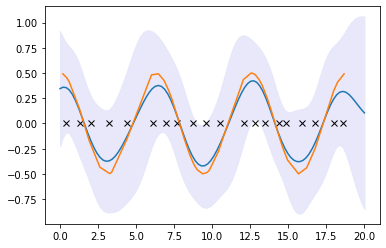

tensor(56.3270, grad_fn=<AddBackward0>)


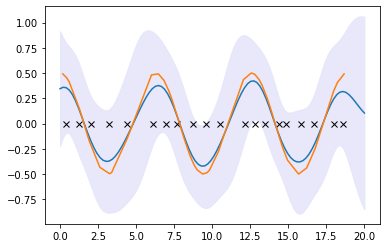

tensor(56.3271, grad_fn=<AddBackward0>)


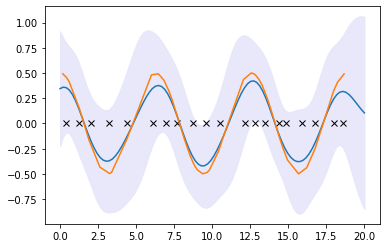

tensor(56.3270, grad_fn=<AddBackward0>)


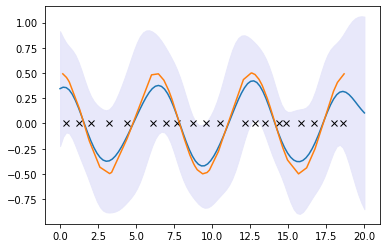

tensor(56.3271, grad_fn=<AddBackward0>)


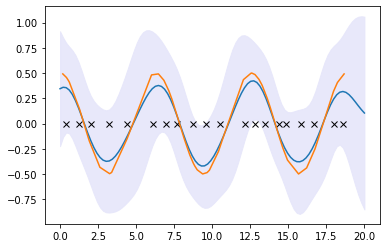

tensor(56.3271, grad_fn=<AddBackward0>)


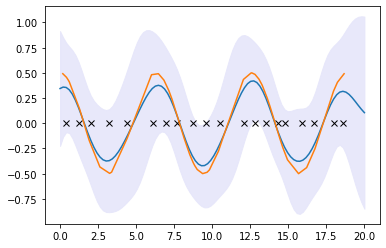

tensor(56.3271, grad_fn=<AddBackward0>)


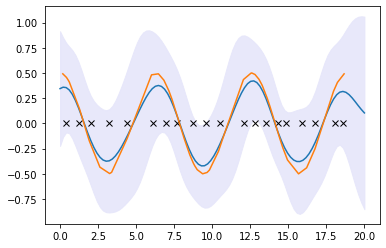

tensor(56.3271, grad_fn=<AddBackward0>)


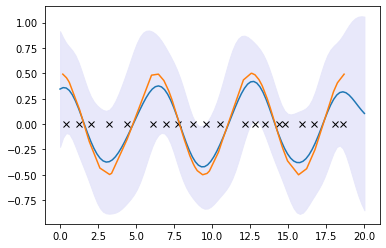

tensor(56.3271, grad_fn=<AddBackward0>)


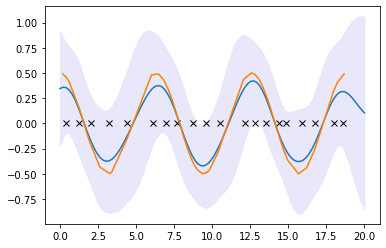

tensor(56.3271, grad_fn=<AddBackward0>)


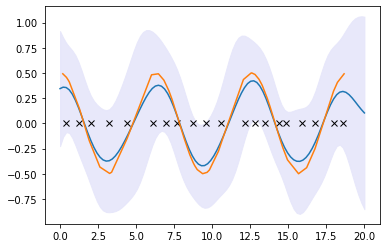

In [22]:
gp.learn( xt.reshape((-1,1)), yt )